In [1]:
import os
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
sns.set()

In [2]:
from pandas_datareader import data
# Only get the adjusted close.
rawData = data.DataReader("SI=F", 
                       start='2000-1-1', 
                       end='2020-4-30', 
                       data_source='yahoo')

rawData.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5048.000000,5048.000000,5048.000000,5048.000000,5.048000e+03,5048.000000
mean,15.133639,14.924146,15.035435,15.029906,1.505991e+05,15.029906
std,8.557144,8.358698,8.464873,8.457472,2.274977e+06,8.457472
min,4.026000,4.026000,4.026000,4.026000,0.000000e+00,4.026000
25%,7.183750,7.136250,7.161500,7.164750,3.000000e+00,7.164750
50%,15.256000,15.087500,15.185000,15.191000,3.100000e+01,15.191000
75%,18.139250,18.005250,18.090250,18.070750,1.340000e+02,18.070750
max,49.520000,47.540001,48.459999,48.584000,6.980156e+07,48.584000


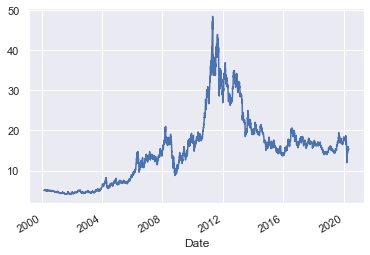

In [3]:
rawData['Open'].plot()

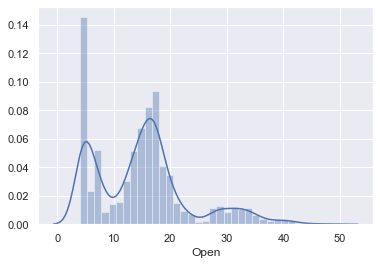

In [4]:
sns.distplot(rawData['Open'])

In [5]:
# TRYING TO REDUCE ON MULTI-COLLINEARITY EARLY BY FINDING RELATIONSHIP OF DATA
rawData['0.5(O+C)'] = ( rawData['Open'] + rawData['Close'] ) * 0.5
rawData['0.5(H+L)'] = ( rawData['High'] + rawData['Low'] ) * 0.5
rawData['0.25(O+C)(H+L)'] = rawData['0.5(O+C)'] * rawData['0.5(H+L)']
rawData.head()

,High,Low,Open,Close,Volume,Adj Close,0.5(O+C),0.5(H+L),0.25(O+C)(H+L)
Date,,,,,,,,,
2000-02-28,5.095,5.020,5.045,5.048,14203.0,5.048,5.0465,5.0575,25.522673
2000-02-29,5.090,5.035,5.065,5.048,2830.0,5.048,5.0565,5.0625,25.598531
2000-03-01,5.130,5.050,5.070,5.073,511.0,5.073,5.0715,5.0900,25.813936
2000-03-02,5.105,5.000,5.105,5.008,645.0,5.008,5.0565,5.0525,25.547966
2000-03-03,5.110,5.000,5.020,5.099,307.0,5.099,5.0595,5.0550,25.575773


In [6]:
# LETS MAKE AN EXTRACT DATASET OF CURRENT OPEN DATA vs PREVIOUS DAY DATA 
# WE ARE TRYING TO PREDICT CURRENT PRICE BASING ON PREVIOUS DAY DATA
extract  = pd.DataFrame(data = { 'Open' : rawData['Open'][1:len(rawData)].to_numpy(), 'AvOC' : rawData['0.5(O+C)'][ : len(rawData) - 1].to_numpy(), 'AvHL' : rawData['0.5(H+L)'][ : len(rawData) - 1].to_numpy(), 'AvOC-HL' : rawData['0.25(O+C)(H+L)'][ : len(rawData) - 1].to_numpy() })
extract.head()

,Open,AvOC,AvHL,AvOC-HL
0,5.065,5.0465,5.0575,25.522673
1,5.070,5.0565,5.0625,25.598531
2,5.105,5.0715,5.0900,25.813936
3,5.020,5.0565,5.0525,25.547966
4,5.090,5.0595,5.0550,25.575773


In [7]:
# LETS USE STATS MODELS TO CHECK THE RELATIONSHIP OF THE Y = B1(X) + C USING LEAST-SQUARES
x = extract['AvOC-HL']
y = extract['Open']
x1 = sm.add_constant(x)
result = sm.OLS(y, x1).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Open   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 5.053e+04
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        17:31:53   Log-Likelihood:                -11886.
No. Observations:                5047   AIC:                         2.378e+04
Df Residuals:                    5045   BIC:                         2.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7792      0.048    161.102      0.000       7.685       7.874
AvOC-HL        0.0244      0.000    224.781      0.000       0.024       0.025
==============================================================================
Omnibus:                      679.163   Durbin-Watson:                   0.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1005.394
Skew:                          -0.989   Prob(JB):                    4.80e-219
Kurtosis:                       3.933   Cond. No.                         598.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

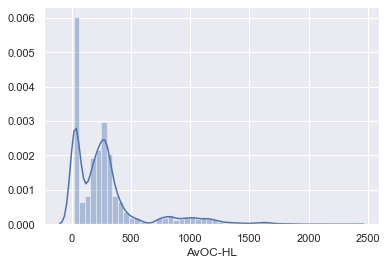

In [8]:
sns.distplot(extract['AvOC-HL'])

In [9]:
# LETS REMOVE THE OUTLIERS
extract = extract[ extract['AvOC-HL']<extract['AvOC-HL'].quantile(0.75) ]
extract.describe()

,Open,AvOC,AvHL,AvOC-HL
count,3785.000000,3785.000000,3785.000000,3785.000000
mean,11.356704,11.350482,11.348553,153.909078
std,5.015756,5.011160,5.009898,108.896522
min,4.026000,4.026000,4.026000,16.208676
25%,5.555000,5.571000,5.585000,31.114034
50%,13.015000,13.010000,13.015000,169.208074
75%,16.129999,16.119000,16.118500,259.926935
max,18.712000,18.153000,18.097501,327.067201


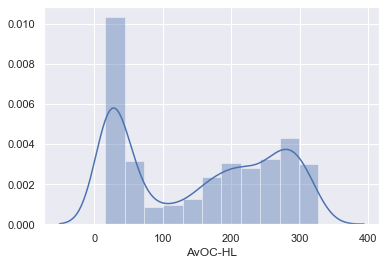

In [10]:
# THE OBSERVED PLOT IS A BETTER NORMALLY DISTRIBUTED PRESENTATION OF THE DATA
sns.distplot(extract['AvOC-HL'])

In [11]:
# SINCE NORMALITY IS IMPROVED WE EXPECT R-SQUARED TO ALSO IMPROVE
x2 = extract['AvOC-HL']
y2 = extract['Open']
xx = sm.add_constant(x2)
results = sm.OLS(y2, xx).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Open   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.868e+05
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        17:32:05   Log-Likelihood:                -4056.0
No. Observations:                3785   AIC:                             8116.
Df Residuals:                    3783   BIC:                             8129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3384      0.020    218.106      0.000       4.299       4.377
AvOC-HL        0.0456      0.000    432.202      0.000       0.045       0.046
==============================================================================
Omnibus:                      940.421   Durbin-Watson:                   0.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.269
Skew:                           0.239   Prob(JB):                     1.46e-43
Kurtosis:                       1.989   Cond. No.                         326.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

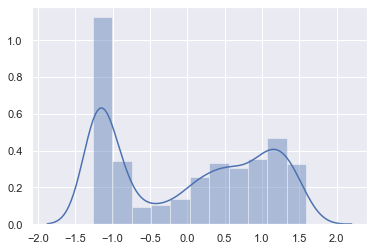

In [12]:
# LETS MAKE THE LINEAR REGRESSION MODEL

# THE TARGETS ARE THE OPENING PRICES
targets = extract['Open']

# THE INPUTS ARE FROM THE FORMULA 0.25(O-C)(H-L) 
inputs = extract['AvOC-HL'].to_numpy().reshape(-1,1)

# LETS SCALE THE INPUTS
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(inputs)
scaled_inputs = scaler.transform(inputs)
sns.distplot(scaled_inputs)

Text(0, 0.5, 'Predictions (y_)')

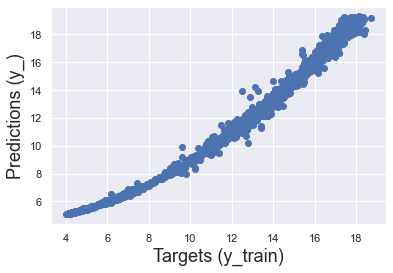

In [13]:
# TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

# 80% - 20% split
x_train, x_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size = 0.2, train_size = 0.8, random_state = 365)

# CREATE A REGRESSION
from sklearn.linear_model import LinearRegression

regs = LinearRegression()
regs.fit( x_train, y_train )

# LETS TRAIN THE MODEL
y_ = regs.predict(x_train)

plt.scatter(y_train, y_)
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_)',size=18)

Text(0.5, 1.0, 'Residuals')

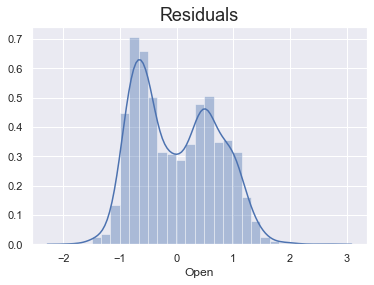

In [14]:
sns.distplot(y_train - y_)
plt.title("Residuals", size=18)

In [15]:
regs.score(x_train,y_train)

0.9799504705050482

In [16]:
# LETS EXTRACT THE BIAS AND WEIGHTS
bias = regs.intercept_
weight = regs.coef_
print(bias, weight)

11.370760159417516 [4.97041858]


Text(0, 0.5, 'Predictions (y_t)')

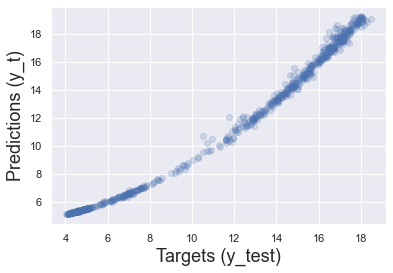

In [17]:
# TESTING THE MODEL
y_t = regs.predict(x_test)

plt.scatter(y_test, y_t, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_t)',size=18)

In [18]:
# LETS INVESTIGATE WHAT THE RESULTS ARE SHOWING
scores = pd.DataFrame(data = { 'Predictions': y_t, 'Targets': y_test })
scores['Residue'] = scores['Targets'] - scores['Predictions']
scores['Loss%'] = scores['Residue'] / scores['Targets'] * 100
scores.describe()

,Predictions,Targets,Residue,Loss%
count,757.000000,757.000000,757.000000,757.000000
mean,11.479833,11.409553,-0.070279,-2.354030
std,5.070299,5.093960,0.700966,8.880897
min,5.095869,4.048000,-1.747284,-25.886108
25%,5.577696,5.250000,-0.663723,-7.960497
50%,12.212411,13.165000,-0.182770,-1.403763
75%,16.410342,16.245001,0.537344,4.870950
max,19.228327,18.468000,1.632912,13.721947


In [19]:
scores.head()

,Predictions,Targets,Residue,Loss%
18,5.527574,5.110000,-0.417574,-8.171704
1095,6.327171,6.500000,0.172829,2.658909
816,5.266822,4.538000,-0.728822,-16.060427
3797,17.683896,17.065001,-0.618895,-3.626693
892,5.600104,5.260000,-0.340104,-6.465850
